In [26]:
import pandas as pd
import numpy as np

from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import HalvingRandomSearchCV as HRSCV
from sklearn.ensemble import RandomForestRegressor

from project_module import data_cleaning
from project_module import feature_engineering
from project_module import regression_report

from sklearn.cluster import KMeans
from sklearn import metrics

import matplotlib.pyplot as plt

## Data Cleaning

In [27]:
train = pd.read_csv('C:/Users/a1298/Desktop/Kaggle housing price/train.csv')
test = pd.read_csv('C:/Users/a1298/Desktop/Kaggle housing price/test.csv')
total = data_cleaning(train, test)
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 364
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallCo

## Feature Engineering

In [28]:
total_fe = feature_engineering(total)
total_fe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 364
Data columns (total 90 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MSSubClass         1460 non-null   int64  
 1   MSZoning           1460 non-null   int64  
 2   LotFrontage        1460 non-null   float64
 3   LotArea            1460 non-null   int64  
 4   Street             1460 non-null   int32  
 5   Neighborhood       1460 non-null   int32  
 6   Condition1         1460 non-null   int32  
 7   Condition2         1460 non-null   int64  
 8   HouseStyle         1460 non-null   int32  
 9   OverallQual        1460 non-null   int64  
 10  OverallCond        1460 non-null   int64  
 11  RoofStyle          1460 non-null   int64  
 12  RoofMatl           1460 non-null   int32  
 13  Exterior1st        1460 non-null   int32  
 14  Exterior2nd        1460 non-null   int32  
 15  MasVnrType         1460 non-null   int64  
 16  MasVnrArea         1460 n

## Binning with KMeans

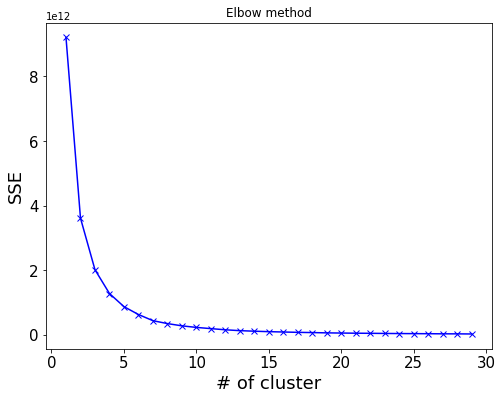

In [30]:
#Elbow method
sse_list=[]
ks = range(1,30)
for k in ks:
    KM = KMeans(n_clusters=k).fit(total_fe.loc[:,(total_fe.columns=='SalePrice')])
    sse_list.append(KM.inertia_) 

plt.figure(figsize=(8,6)) 
plt.plot(np.array(ks), sse_list, 'bx-')
plt.rcParams['figure.figsize'] = [12,8]
plt.xlabel('# of cluster',fontsize=18)
plt.ylabel('SSE',fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Elbow method")
plt.show()  


from sklearn.preprocessing import KBinsDiscretizer

target = total_fe['SalePrice']
est = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans')
Xt = est.fit_transform(total_fe[['SalePrice']]) 

total_fe['Price_class'] = Xt

## Train test split

In [31]:
target = 'SalePrice'
train_size = train.shape[0]
Y = total_fe[target]
X = total_fe.drop(columns = [target])

# training data
x_train = np.array(X[:train_size])
y_train = np.array(Y[:train_size])

# testing data
x_test = np.array(X[train_size: ])
y_test = np.array(Y[train_size: ])

print(f'Training: {x_train.shape, y_train.shape}')
print(f'Testing: {x_test.shape, y_test.shape}')

Training: ((1095, 90), (1095,))
Testing: ((365, 90), (365,))


## Model tuning

In [32]:
RF = RandomForestRegressor()

# set searching hyperparameters
search_params = {
    'n_estimators': np.arange(20, 101),
    'max_depth': np.arange(7, 20),
    'ccp_alpha': np.abs(norm(loc = 1.5, scale = 0.5).rvs(size=20)),
    'criterion': ['mae', 'mse'],
    'min_samples_split': np.arange(2, 8),
    'min_impurity_decrease': np.abs(norm(loc = 1, scale = 0.5).rvs(size=30))
}

# set Successive Halving algorithm
SH_search = HRSCV(
    estimator = RF, param_distributions = search_params, n_candidates = 80, 
    factor = 2, resource = 'n_samples', max_resources='auto', min_resources='smallest', 
    aggressive_elimination=False, cv=3, scoring='neg_mean_absolute_error', refit=True,
    return_train_score=True, random_state=None, n_jobs=4, verbose=0
)

SH_search.fit(x_train, y_train)

print(f'Best score is {(-1) * SH_search.best_score_:.4f}')
print(f'Best params is {SH_search.best_params_}')

Best score is 18890.8429
Best params is {'n_estimators': 75, 'min_samples_split': 2, 'min_impurity_decrease': 1.1415833585273454, 'max_depth': 19, 'criterion': 'mae', 'ccp_alpha': 1.7136670699840404}


In [33]:
best_param = SH_search.best_params_.copy()
best_param['n_jobs'] = 4

RF = RandomForestRegressor(**best_param)

RF.fit(x_train, y_train)

pred = RF.predict(x_test)
regression_report(y_test, pred, True)

mse = 583788721.5252
mae = 14760.1426
rmse = 24161.7202
mape = 0.0873
